# Pytorch 快速使用手册

In [2]:
import torch
import torch.nn as nn
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="2"
print(torch.__version__)


1.2.0+cpu


## 查看是否有GPU

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ##判断是否有gpu
if torch.cuda.is_available():
    cudnn.benchmark = True

    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    #tf.set_random_seed(seed)
seed_everything(2019)


## 基本命令

In [8]:
x = torch.randn(2,3,224,224)
print(x.size(),x.type())
y = torch.randn(2,3,224,224)
z = x+y

print(z.size(),z.type())
print(y.add_(x).size())
print(y[1,1,1,:2])


torch.Size([2, 3, 224, 224]) torch.FloatTensor
torch.Size([2, 3, 224, 224]) torch.FloatTensor
torch.Size([2, 3, 224, 224])
tensor([ 0.1459, -2.1029])


### torch.Tensor与numpy相互转化

In [14]:
# torch.Tensor ->numpy
a = torch.ones(5)
print("a:",a.size(),type(a))
b = a.numpy()
print('b:',b.shape,type(b))

# numpy ->torch.Tensor
e=torch.from_numpy(b)
print('b',type(b))
print('e',type(e))

a: torch.Size([5]) <class 'torch.Tensor'>
b: (5,) <class 'numpy.ndarray'>
b <class 'numpy.ndarray'>
e <class 'torch.Tensor'>


### torch.Tensor与cuda相互转化

In [16]:
# torch.Tensor ->cuda 
x = torch.randn(2,3,224,224)
y = torch.randn(2,3,224,224)
if torch.cuda.is_available():
    x = x.cuda()
    x = x.to(device)
    y = y.cuda()
    x + y

# cuda->torch.Tensor 
b = x.cpu()
c = y.cpu()

### torch.Tensor与Variable相互转化

In [15]:
# torch.Tensor ->Variable
from torch.autograd import Variable
x = torch.randn(2,3,224,224)
y = Variable(x)
print('y:',type(y),y.size(),y.type())

# Variable -> torch.Tensor
c=y.data#通过 Variable.data 方法相当于将Variable中的torch.tensor 取出来
print('c:',c.type(),c.shape)


y: <class 'torch.Tensor'> torch.Size([2, 3, 224, 224]) torch.FloatTensor
c: torch.FloatTensor torch.Size([2, 3, 224, 224])


### numpy与list相互转化

In [19]:
#  numpy -> list
import numpy as np
d = np.random.random((2,4))
f1=d.tolist()
f2=list(d)

# list -> numpy
g=np.asarray(f2)
g=np.array(f2)
print('f1:',type(f1))
print('g:',type(g))


f1: <class 'list'>
g: <class 'numpy.ndarray'>


### long,int,double,float,byte类型转化

In [21]:

x = torch.randn(2,3,32,32)
print(x.type())
y = x.float()
print("float:",y.type())
y = x.long()
print("long:",y.type())
y = x.int()
print("int:",y.type())
y = x.double()
print("double:",y.type())
y = x.byte()
print("byte:",y.type())

# # 一般只要在Tensor后加long(), int(), double(),float(),byte()等函数就能将Tensor进行类型转换；
# 例如：Torch.LongTensor--->Torch.FloatTensor, 直接使用data.float()即可

torch.FloatTensor
float: torch.FloatTensor
long: torch.LongTensor
int: torch.IntTensor
double: torch.DoubleTensor
byte: torch.ByteTensor


### Autograd: 自动求导

In [22]:
x = Variable(torch.ones(2, 2), requires_grad=True)
print("x =", x)
y = x + 2
print("x + 2 =", y)
print("(x + 2) grad_fn", y.grad_fn)
print("x grad_fn",x.grad_fn)

x = tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
x + 2 = tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
(x + 2) grad_fn <AddBackward0 object at 0x7fe24c70eb70>
x grad_fn None


In [24]:
z = y * y * 3
out = z.mean()

print(z, out)
out.backward() ## out最好是标量
## out = z
## out.backward(torch.ones(out.shape))
print("x grad=", x.grad)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)
x grad= tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


## 搭建数据集

In [ ]:
class Segmentation(object):
    def __init__(self, root, mode=None,shuffle=True, transform=None):
        super(Segmentation, self).__init__()

        self.images, self.masks = _get_pairs(root, mode,shuffle)
        self.mode = mode
        self.transform = transform
        self.shuffle = shuffle
        self.num_class = 5

    def __getitem__(self, index):

        img = cv2.imread(self.images[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index],-1)
        # general resize, normalize and to Tensor
        if self.transform is not None:
            img = self.transform(img)

        return torch.FloatTensor(img), torch.LongTensor(mask)

    def __len__(self):
        return len(self.images)

    @property
    def pred_offset(self):
        return 1

    @property
    def classes(self):
        """Category names."""
        return ("0","1","2","3","4")

def _get_pairs(folder, mode='train', shuffle=True):

    if mode == 'train':
        img_folder = os.path.join(folder, '%d_imgs'%crop_size)
        mask_folder = os.path.join(folder, '%d_label'%crop_size)
    else:
        img_folder = os.path.join(folder, '%d_imgs_val'%crop_size)
        mask_folder = os.path.join(folder, '%d_label_val'%crop_size)

    img_paths = glob(img_folder+"/*")
    mask_paths = glob(mask_folder + "/*")
    if shuffle:
        img_paths = np.array(img_paths)
        mask_paths = np.array(mask_paths)
        index = [i for i in range(len(img_paths))]
        np.random.shuffle(index)
        img_paths = img_paths[index]
        mask_paths = mask_paths[index]

    return img_paths, mask_paths

# dataset and dataloader
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.2676, 0.2676, 0.2676], [0.180, 0.180, 0.180]),
])
data_kwargs = {'transform': input_transform}
train_dataset = Segmentation("../zz", mode='train',shuffle=True,**data_kwargs)
val_dataset = Segmentation("../zz", mode='val',shuffle=False,**data_kwargs)
print("train_dataset :",len(train_dataset))
print("val_dataset:",len(val_dataset))
train_loader = data.DataLoader(dataset = train_dataset, batch_size= batch_size)
val_loader = data.DataLoader(dataset = val_dataset, batch_size= batch_size)


## 搭建网络

In [26]:
import torch
from torch.autograd import Variable
import torch.nn 
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5*5 square convolution
        # kernel

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def weights_init(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, mean = 0, std = 1)
                nn.init.constant_(module.bias, 0)
    
model = Net()
print(model)
model.weights_init()
for module in model.modules():
    if isinstance(module, nn.Conv2d):
        weights = module.weight
        weights = weights.reshape(-1).detach().cpu().numpy()
        print(module.bias)                                       # Bias to zero
        plt.hist(weights)
        plt.show()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### modules() vs children()

In [3]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convBN =  nn.Sequential(nn.Conv2d(10,10,3), nn.BatchNorm2d(10))
        self.linear =  nn.Linear(10,2)

    def forward(self, x):
        pass

Net = myNet()
# Net = myNet().half() ## 指定模型为半精度运行

print("Printing children\n------------------------------")
print(list(Net.children()))
print("\n\nPrinting Modules\n------------------------------")
print(list(Net.modules()))

Printing children
------------------------------
[Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Linear(in_features=10, out_features=2, bias=True)]


Printing Modules
------------------------------
[myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
), Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)), BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Linear(in_features=10, out_features=2, bias=True)]


### 打印网络信息

In [4]:
for x in Net.named_modules():
  print(x[0], x[1], "\n-------------------------------")

 myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
) 
-------------------------------
convBN Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
-------------------------------
convBN.0 Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)) 
-------------------------------
convBN.1 BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
-------------------------------
linear Linear(in_features=10, out_features=2, bias=True) 
-------------------------------


### 不同的层设置不同的学习率

In [ ]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10,5)
        self.fc2 = nn.Linear(5,2)

    def forward(self, x):
        return self.fc2(self.fc1(x))

Net = myNet()
# optimiser = torch.optim.SGD(Net.parameters(), lr = 0.5)

#######################################################################################################
optimiser = torch.optim.SGD([{"params": Net.fc1.parameters(), 'lr' : 0.001, "momentum" : 0.99},
                             {"params": Net.fc2.parameters()}], lr = 0.01, momentum = 0.9)


#######################################################################################################
params_bias = []
params_wts = []
# seperate the bias and weights parameters
for name, parameter in Net.named_parameters():
  if "bias" in name:
    params_bias.append(parameter)
  elif "weight" in name:
    params_wts.append(parameter)

# Set the optimiser to have different hyperparameters for bias and weights
optimiser = torch.optim.SGD([{"params": params_bias, 'lr' : 0.001, "momentum" : 0.99},
                             {"params": params_wts}], lr = 0.01, momentum = 0.9)

## 获得网络信息

### 保存和加载网络模型

In [ ]:
torch.save(Net, "net.pth")
Net = torch.load("net.pth")
print(Net)

# Save and load only the model parameters (recommended).
torch.save(resnet.state_dict(), 'params.ckpt')
resnet.load_state_dict(torch.load('params.ckpt'))

### 获得网络的权重信息


In [30]:
model_dict = net.state_dict()
for k,v in model_dict.items():
    print("layer:",k,v.size())

layer: conv1.weight torch.Size([6, 1, 5, 5])
layer: conv1.bias torch.Size([6])
layer: conv2.weight torch.Size([16, 6, 5, 5])
layer: conv2.bias torch.Size([16])
layer: fc1.weight torch.Size([120, 400])
layer: fc1.bias torch.Size([120])
layer: fc2.weight torch.Size([84, 120])
layer: fc2.bias torch.Size([84])
layer: fc3.weight torch.Size([10, 84])
layer: fc3.bias torch.Size([10])


### 加载网络预训练权重模型

In [31]:
def load_pretrainedweights(model, pretrained_model):
    model_dict = model.state_dict()
    pretrained_dict = torch.load(pretrained_model)
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

load_pretrainedweights(model,pretrained_model="model.ckpt")

### 检查模型是否正确加载权重

In [ ]:
def check_weight_loaded( ):

    model =  EfficientNet_B4()
    model_dict_v1 = model.state_dict()
    model =  EfficientNet_B4()
    model_dict_v2 = model.state_dict()
    for k in model_dict_v1.keys():
        try:
            assert model_dict_v1[k].data.numpy().all() == model_dict_v2[k].data.numpy().all()
        except AssertionError as e:
            print("failed to load weights!")
            break
    else:
        print("--> model weight loading is  successful!")


### 模型权重初始化

In [ ]:
import  torch.nn from init
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv')!="-1":
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear')!="-1":
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d')!="-1":
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)
        
model.apply(weights_init_normal)

### 加载网络模型

In [ ]:
model.load_state_dict(torch.load(weight_path, map_location=lambda storage, loc: storage))
model.load_state_dict(torch.load(weight_path, map_location='cpu'))
model = model.module#才是你的模型            

### 获得网络的中间某一层的输出和参数量


In [33]:
print(net)
from torchsummary import summary
summary(net,(1,32,32))

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB

### 数据并行

In [38]:
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
print("model parameters device:", next(model.parameters()).is_cuda)

## 迁移学习

In [ ]:
# Download and load the pretrained ResNet-18.
from torchvision.models import resnet18

resnet = resnet18(pretrained=True)
# If you want to finetune only the top layer of the model, set as below.
for param in resnet.parameters():
    param.requires_grad = False

# Replace the top layer for finetuning.
resnet.fc = nn.Linear(resnet.fc.in_features, 100)  # 100 is an example.

# Forward pass.
images = torch.randn(64, 3, 224, 224)
outputs = resnet(images)
print (outputs.size())     # (64, 100)

## hook

由于pytorch会自动舍弃图计算的中间结果，所以想要获取这些数值就需要使用钩子函数。
钩子函数包括Variable的钩子和nn.Module钩子，用法相似。

### register_hook

In [ ]:
import torch
from torch.autograd import Variable

grad_list = []
def print_grad(grad):
    grad_list.append(grad)

x = Variable(torch.ones(2, 1), requires_grad=True)
y = x + 2
z = torch.mean(torch.pow(y, 2))
lr = 1e-3
y.register_hook(print)
y.register_hook(print_grad)
z.backward()
x.data -= lr * x.grad.data
print(grad_list)

In [5]:
import torch 
import torch.nn as nn

def hook_fn(m, i, o):
    print(m)
    print("------------Input Grad------------")

    for grad in i:
        try:
            print(grad.shape)
        except AttributeError: 
            print ("None found for Gradient")

    print("------------Output Grad------------")
    for grad in o:  
        try:
            print(grad.shape)
        except AttributeError: 
            print ("None found for Gradient")
    print("\n")

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3,10,2, stride = 2)
        self.relu = nn.ReLU()
        self.flatten = lambda x: x.view(-1)
        self.fc1 = nn.Linear(160,5)
   
  
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.fc1(self.flatten(x))

net = myNet()

net.conv.register_backward_hook(hook_fn)
net.fc1.register_backward_hook(hook_fn)
inp = torch.randn(1,3,8,8)
out = net(inp)
(1 - out.mean()).backward()

Linear(in_features=160, out_features=5, bias=True)
------------Input Grad------------
torch.Size([5])
torch.Size([5])
------------Output Grad------------
torch.Size([5])


Conv2d(3, 10, kernel_size=(2, 2), stride=(2, 2))
------------Input Grad------------
None found for Gradient
torch.Size([10, 3, 2, 2])
torch.Size([10])
------------Output Grad------------
torch.Size([1, 10, 4, 4])




In [8]:
visualisation = {}

inp = torch.randn(1,3,8,8)

def hook_fn(m, i, o):
    visualisation[m] = o 

net = myNet()

for name, layer in net._modules.items():
    layer.register_forward_hook(hook_fn)

out = net(inp) 

## 常用的损失函数

In [37]:

def dice_loss(logits,true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


criterion = nn.CrossEntropyLoss().to(device)
criterion = nn.BCELoss().to(device)
criterion = dice_loss

### 自定义损失函数

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1:自定义损失函数
def my_mse_loss(x, y):
    return torch.mean(torch.pow((x - y), 2))

## 2: 继承nn.Mdule
class My_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        return torch.mean(torch.pow((x - y), 2))

    


x_train = np.array([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168],
                    [9.779], [6.182], [7.59], [2.167], [7.042],
                    [10.791], [5.313], [7.997], [3.1]], dtype=np.float32)

y_train = np.array([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573],
                    [3.366], [2.596], [2.53], [1.221], [2.827],
                    [3.465], [1.65], [2.904], [1.3]], dtype=np.float32)

# 将numpy数据转化为torch的张量
inputs = torch.from_numpy(x_train)
targets = torch.from_numpy(y_train)

input_size = 1
output_size = 1
num_epochs = 60
learning_rate = 0.001

# 第三步： 构建模型，构建一个一层的网络模型
model = nn.Linear(input_size, output_size)

# 与模型相关的配置、损失函数、优化方式
# 使用自定义函数，等价于criterion = nn.MSELoss()
criterion = My_loss()

# 定义迭代优化算法， 使用的是随机梯度下降算法
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_history = []
# 第四步：训练模型，迭代训练
for epoch in range(num_epochs):
    #  前向传播计算网络结构的输出结果
    outputs = model(inputs)

    # 计算损失函数
    loss = criterion(outputs, targets)

    # 反向传播更新参数，三步策略，归零梯度——>反向传播——>更新参数
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 打印训练信息和保存loss
    loss_history.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

Epoch [5/60], Loss: 0.2952
Epoch [10/60], Loss: 0.2376
Epoch [15/60], Loss: 0.2142
Epoch [20/60], Loss: 0.2047
Epoch [25/60], Loss: 0.2008
Epoch [30/60], Loss: 0.1991
Epoch [35/60], Loss: 0.1984
Epoch [40/60], Loss: 0.1981
Epoch [45/60], Loss: 0.1979
Epoch [50/60], Loss: 0.1978
Epoch [55/60], Loss: 0.1977
Epoch [60/60], Loss: 0.1976


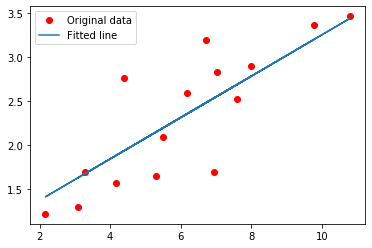

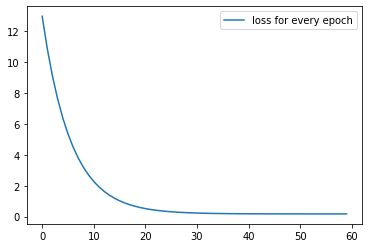

In [2]:
# 第五步：结果展示。画出原y与x的曲线与网络结构拟合后的曲线
predicted = model(torch.from_numpy(x_train)).detach().numpy()  # 模型输出结果

plt.plot(x_train, y_train, 'ro', label='Original data')  # 原始数据
plt.plot(x_train, predicted, label='Fitted line')  # 拟合之后的直线
plt.legend()
plt.show()

# 画loss在迭代过程中的变化情况
plt.plot(loss_history, label='loss for every epoch')
plt.legend()
plt.show()

### NLLLoss和CrossEntropyLoss

In [6]:

import torch.nn as nn
x=torch.randn(4,3)
print("x:", x)
sm = nn.Softmax(dim =1)
print("softmax x:", sm(x))
print("log:", torch.log(sm(x)))

loss = nn.NLLLoss()
target = torch.tensor([0,2,1,1])
print("NLLLoss:",loss(torch.log(sm(x)),target))

loss = nn.CrossEntropyLoss() # Softmax–Log–NLLLoss
print("CrossEntropyLoss :", loss(x, target))

x: tensor([[ 0.3429,  0.9050, -2.3298],
        [ 1.8048, -2.6157, -0.1287],
        [ 0.0999, -1.1667,  0.7500],
        [-0.6020, -0.1751,  0.4742]])
softmax x: tensor([[0.3542, 0.6214, 0.0245],
        [0.8645, 0.0104, 0.1251],
        [0.3127, 0.0881, 0.5991],
        [0.1829, 0.2804, 0.5367]])
log: tensor([[-1.0379, -0.4759, -3.7107],
        [-0.1456, -4.5660, -2.0790],
        [-1.1624, -2.4289, -0.5123],
        [-1.6986, -1.2716, -0.6224]])
NLLLoss: tensor(1.7044)
CrossEntropyLoss : tensor(1.7044)


### BCEWithLogitsLoss和BCELOSS

In [12]:
import torch.nn as nn
x=torch.randn(3,3)
print("x:", x)
sm = nn.Sigmoid()
print("Sigmoid x:", sm(x))


target = torch.FloatTensor([[0,1,1],[1,0,0],[0,1,0]])
loss = nn.BCELoss() # Sigmoid-BCELoss
print("BCELoss :", loss(sm(x), target))

loss = nn.BCEWithLogitsLoss() # Sigmoid-BCELoss
print("CrossEntropyLoss :", loss(x, target))


x: tensor([[-1.1235, -0.0948, -0.8286],
        [ 0.8362, -1.9370,  0.7749],
        [ 1.1140, -0.2855,  1.0280]])
Sigmoid x: tensor([[0.2454, 0.4763, 0.3039],
        [0.6977, 0.1260, 0.6846],
        [0.7529, 0.4291, 0.7365]])
BCELoss : tensor(0.8267)
CrossEntropyLoss : tensor(0.8267)


## 常见的指标

In [ ]:

predict = output.argmax(dim = 1)
confusion_matrix =torch.zeros(2,2)
for p,t in zip(predict.view(-1), target.view(-1)):
    confusion_matrix[t.long(), p.long()] += 1
a_p =(confusion_matrix.diag() / confusion_matrix.sum(1))[0]
b_p = (confusion_matrix.diag() / confusion_matrix.sum(1))[1]
a_r =(confusion_matrix.diag() / confusion_matrix.sum(0))[0]
b_r = (confusion_matrix.diag() / confusion_matrix.sum(0))[1]


## 常用的优化器


In [ ]:
optimizer = torch.optim.SGD(model.parameters(),
                                 lr=lr,
                                 momentum=momentum,
                                 weight_decay=weight_decay)

## 常用的学习率

In [ ]:
# lr scheduling
lr_scheduler = WarmupPolyLR(optimizer,
                                 max_iters=epochs * iters_per_epoch,
                                 power=0.9,
                                 warmup_factor=warmup_factor,
                                 warmup_iters=warmup_iters,
                                 warmup_method=warmup_method)

In [ ]:
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones = [10,20], gamma = 0.1)
scheduler.step()

## 训练过程

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, trian_dataset, val_dataset):
    from tqdm import tqdm
    from collections import deque
    
    train_loss = deque(maxlen=20)
    
    for epoch in range(1,n_epochs+1):
    
        model.train()
        for index,(image,label) in tqdm(enumerate(trian_dataset)):
            
            image = image.to(device)
            label = label.to(device)
            model = model.to(device)
            
            train_preds = model(image)
            loss_train = loss_fn(train_preds, label).to(device)
            train_loss.append(loss_train.item())
            
            optimizer.zero_grad()
            loss_train.backword()
            optimizer.step()
        
        torch.cuda.empty_cache()
        model.eval()
        val_loss = []
        with torch.no_grad():
            for index,(image,label) in tqdm(enumerate(val_dataset)):
                image = image.to(device)
                label = label.to(device)
                model = model.to(device)
                
                val_preds = model(image)
                loss_val = loss_fn(val_preds, label).to(device)
                val_loss.append(loss_val.item())
        
        print("\nepoch:{:d}/{:d}, Lr:{:.6f},Loss:{:.4f},val_loss:{:.4f}".
          format(epoch, n_epochs+1, optimizer.param_groups[0]['lr'],np.mean(trian_loss), np.mean(val_loss)))

### 保持训练记录到csv文件

In [ ]:
import pandas as pd
train_history = np.random.random(1000,6)
x = pd.DataFrame(train_history)
x.columns= ['Loss', 'val_loss', 'val_pixAcc', 'train_pixAcc', 'val_mIoU', 'train_mIoU']
x.to_csv("./checkpoint/%s.csv"%model_name, index=False)

In [ ]:
## 显示gpu
!pip install gputil
from GPUtil import showUtilization as gpu_usage
gpu_usage()